
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [149]:
import os
import spec_funcs as sf
import fit_funcs as ff
from filter_funcs import moving_av
from scipy.signal import fftconvolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
mp.style.use('signature.mplstyle')

path = r"C:\Users\keena\Desktop\YSO_T1"


##### Import Data  
        
        Load data sets & extract time and voltage data


In [150]:
_, file_names = sf.dir_interogate(path)#, extensions=(".csv"))#, ".xlsx"))
file_paths = [os.path.join(path, f_name) for f_name in file_names]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
data_lists = [[data_frame[x].values.tolist() for x in data_frame] for data_frame in data_frames]
length_data_lists = range(len(data_lists))
time_lists = [data_lists[n][0] for n in length_data_lists]
trigger_lists = [data_lists[n][1] for n in length_data_lists]
reference_lists = [data_lists[n][2] for n in length_data_lists]
transmitted_lists = [data_lists[n][3] for n in length_data_lists]


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


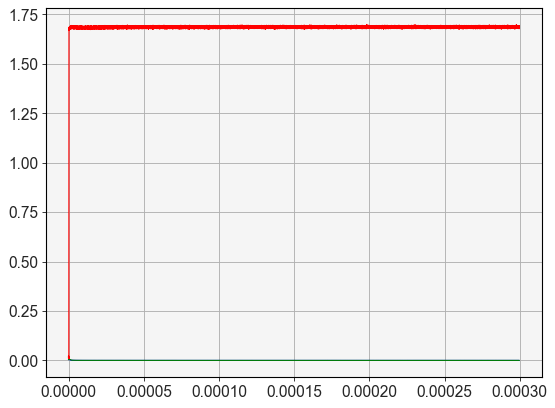

In [151]:
fig, ax = mp.subplots()
ax.plot(time_lists[0], trigger_lists[0], 'r')
ax.plot(time_lists[0], reference_lists[0], 'b')
ax.plot(time_lists[0], transmitted_lists[0], 'g')


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

Text(0.5, 0, 'Relevant Index')

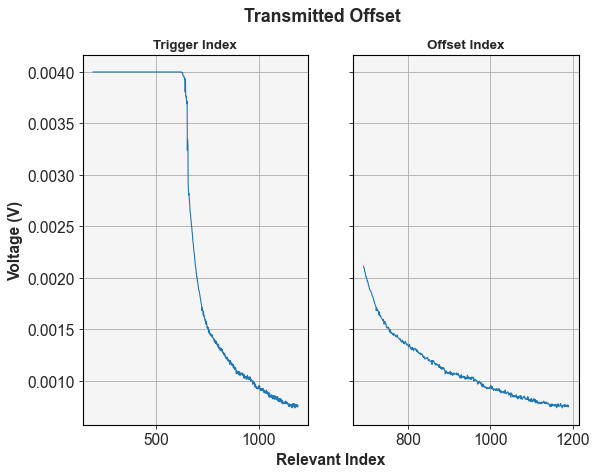

In [152]:
trig_indexes = [int(sf.find_trigger(trigger_list, np.max(trigger_list) * 0.99)) for trigger_list in trigger_lists]
end_index = 1000 + trig_indexes[0]
offset = 500
plt_idx_trig = [x for x in range(trig_indexes[0], end_index, 1)]
plt_idx_off = [x for x in range(trig_indexes[0]+offset, end_index, 1)]

fig, ax = mp.subplots(ncols=2, sharey='all')
fig.suptitle('Transmitted Offset')
ax[0].set_title('Trigger Index')
ax[0].set_ylabel('Voltage (V)')
ax[0].plot(plt_idx_trig, transmitted_lists[0][trig_indexes[0]:end_index])
ax[1].set_title('Offset Index')
ax[1].plot(plt_idx_off, transmitted_lists[0][trig_indexes[0]+offset:end_index])
# add larger subplot to provide common axis labels
fig.add_subplot(111, frameon=False)
mp.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
mp.grid(visible=False)
mp.xlabel('Relevant Index')


##### Process Data  

        Remove negatives and create smoothed and normalised sets

In [153]:
new_trig_index = [value + offset for value in trig_indexes]
time_cut_lists = [time_list[index:-1] for time_list, index in zip(time_lists, new_trig_index)]
trans_cut_lists = [trans_list[index:-1] for trans_list, index in zip(transmitted_lists, new_trig_index)]
list_of_mins = [min(trans_list) for trans_list in trans_cut_lists]
list_of_maxs = [max(trans_list) for trans_list in trans_cut_lists]
avg_window = moving_av(100)
length_avg_window = int(avg_window.shape[0]) // 2
trans_smoothed = [fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists]
trans_avg_cor = [[value - min for value in trans_smooth_list] for trans_smooth_list, min in zip(trans_smoothed, list_of_mins)]
trans_corrected = [[value - min for value in trans_cut_list] for trans_cut_list, min in zip(trans_cut_lists, list_of_mins)]
trans_norm = [[value / max if value != 0 else value for value in trans_set] for trans_set, max in zip(trans_corrected, list_of_maxs)]

C:\Users\keena\AppData\Local\Temp\ipykernel_12060\481878873.py:6: RuntimeWarning: divide by zero encountered in log
  mp.plot(np.log(trans_corrected[0]))


[2.38542339e-03 2.65012925e-06 6.80656167e-05] [5.33741595e-06 5.21260736e-09 9.27589834e-08]


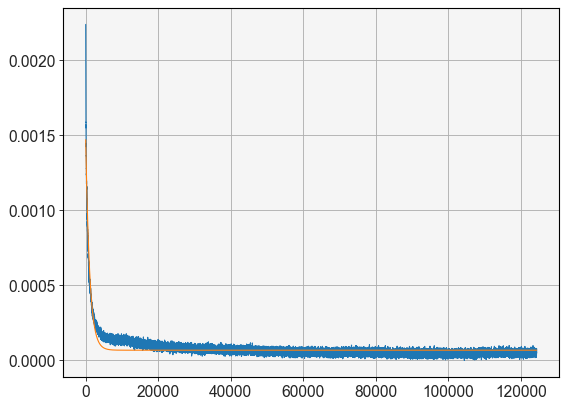

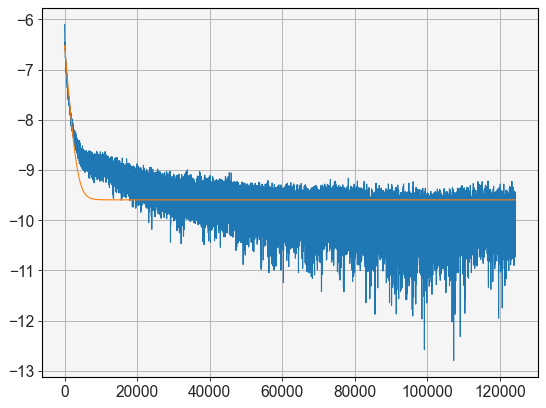

In [154]:
fit, err = ff.fit_exp_decay(time_cut_lists[0], trans_corrected[0], params=(0.0035, 160E-6, list_of_mins[0]))
mp.figure()
mp.plot(trans_corrected[0])
mp.plot(ff.exp_decay(np.array(time_cut_lists[0]), *fit))
mp.figure()
mp.plot(np.log(trans_corrected[0]))
mp.plot(np.log(ff.exp_decay(np.array(time_cut_lists[0]), *fit)))

print(fit, err)

[1.66446891e-04 3.41010510e-03 3.99286307e-05 1.66659384e-06
 5.08443500e-05]


C:\Users\keena\AppData\Local\Temp\ipykernel_12060\3267086652.py:7: RuntimeWarning: divide by zero encountered in log
  mp.plot(np.log(trans_corrected[0])[0:10000])


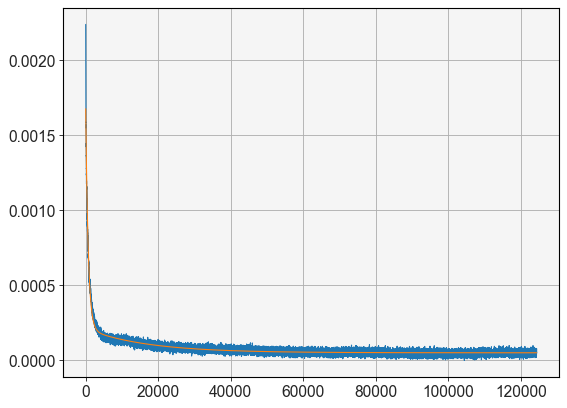

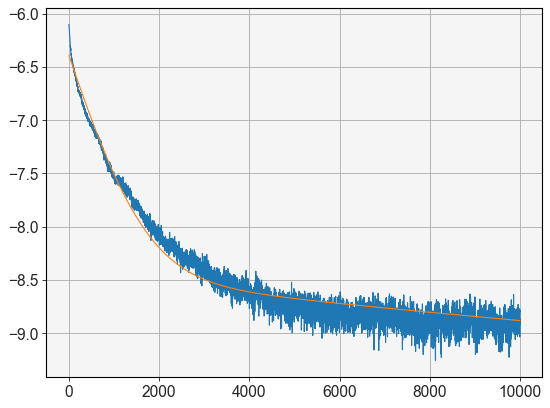

In [155]:
fit, err = ff.fit_dbl_exp_decay(time_cut_lists[0], trans_corrected[0], params=(0.003, 0, 160E-6, 10E-8, list_of_mins[0]))
mp.figure()
mp.plot(trans_corrected[0])
mp.plot(ff.dbl_exp_decay(np.array(time_cut_lists[0]), *fit))
print(fit)
mp.figure()
mp.plot(np.log(trans_corrected[0])[0:10000])
mp.plot(np.log(ff.dbl_exp_decay(np.array(time_cut_lists[0]), *fit))[0:10000])

c:\Users\keena\Documents\University\PhD\Code\Spectroscopy\fit_funcs.py:32: RuntimeWarning: overflow encountered in exp
  return y_1 * np.exp(-x/T1) + y_2 * np.exp(-x/T2) + offset


[1.53422705e-04 2.77620355e-03 4.37754736e-05 1.91183906e-06
 5.00476927e-05] [2.11322782e-07 2.70538712e-06 8.93140039e-08 1.61081930e-09
 4.17184380e-08]


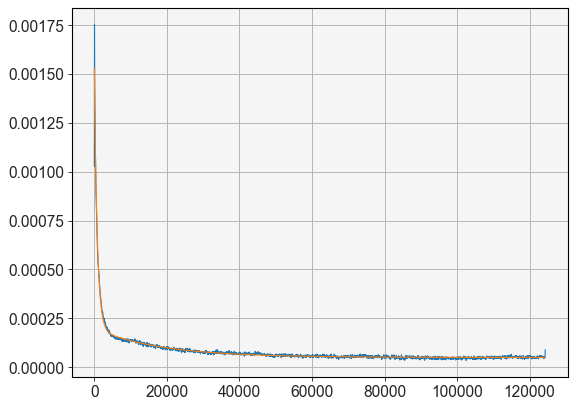

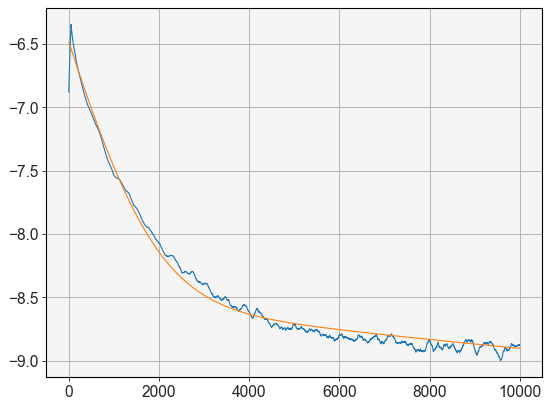

In [156]:
fit, err = ff.fit_dbl_exp_decay(time_cut_lists[0], trans_avg_cor[0], params=(0.002, 0.001, 100E-6, 10E-6, list_of_mins[0]), meth='trf')
mp.figure()
mp.plot(trans_avg_cor[0])
mp.plot(ff.dbl_exp_decay(np.array(time_cut_lists[0]), *fit))
print(fit, err)
mp.figure()
mp.plot(np.log(trans_avg_cor[0])[0:10000])
mp.plot(np.log(ff.dbl_exp_decay(np.array(time_cut_lists[0]), *fit))[0:10000])